#Value Object

In [2]:
class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0
        self._op = _op
        self._backward = lambda:None

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += output.grad
            other.grad += output.grad
        output._backward = _backward

        return output

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        output._backward = _backward

        return output

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        output = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * output.grad
        output._backward = _backward

        return output

    def relu(self):
        output = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (output.data > 0) * output.grad
        output._backward = _backward

        return output


    def backward(self):
        topo = [] # topological sort
        visited = set()
        def buildTopo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    buildTopo(child)
                topo.append(v)
        buildTopo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"




#NN

In [3]:

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

#Importing data

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
import random
X, y = make_moons(n_samples=100, noise=0.1)


#Viz data

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
337
num of para None


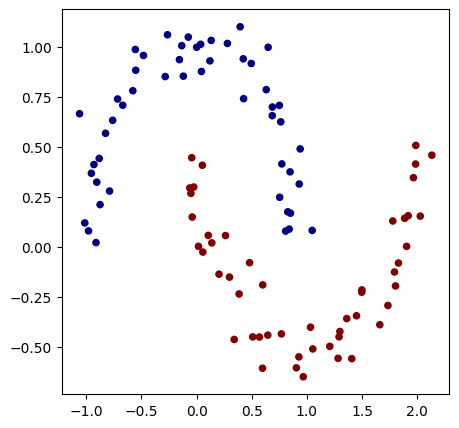

In [10]:

y = y*2 -1
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')
model = MLP(2, [16, 16, 1])
print(model)
print('num of para', print(len(model.parameters())))


#Cal Loss

In [11]:


def Loss(batchSiz=None):
    if batchSiz is None:
        xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batchSiz]
        xb, yb = X[ri], y[ri]

    inputs  = [list(map(Value, xrow)) for xrow in xb]
    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei) for yi, scorei in zip(yb, scores)]
    dataLoss = sum(losses) * (1.0/(len(losses)))

    alpha = 1e-7
    regularLoss = alpha * sum((p*p for p in model.parameters()))

    acc = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

    totalLoss = dataLoss + regularLoss
    return totalLoss, sum(acc) / len(acc)


#Train / Optimiz

In [12]:

for k in range(100):
    totalLoss, acc = Loss()

    model.zero_grad()
    totalLoss.backward()

    learningRate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learningRate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {totalLoss.data}, accuracy {acc*100}%")


step 0 loss 1.2851593046206906, accuracy 28.000000000000004%
step 1 loss -0.4990558341321403, accuracy 70.0%
step 2 loss -8.09538068913663, accuracy 76.0%
step 3 loss -100.3686683256894, accuracy 74.0%
step 4 loss -5223.393111211053, accuracy 74.0%
step 5 loss -7337992.385193767, accuracy 74.0%
step 6 loss -11029476194127.639, accuracy 50.0%
step 7 loss -2.358229745599915e+25, accuracy 50.0%
step 8 loss -1.0464530490873455e+50, accuracy 53.0%
step 9 loss -1.9959517362996236e+99, accuracy 50.0%
step 10 loss -7.04013769453585e+197, accuracy 50.0%


<ipython-input-2-bbc93b962255>:23: RuntimeWarning: overflow encountered in scalar multiply
  output = Value(self.data * other.data, (self, other), '*')
<ipython-input-2-bbc93b962255>:12: RuntimeWarning: invalid value encountered in scalar add
  output = Value(self.data + other.data, (self, other), '+')
<ipython-input-2-bbc93b962255>:27: RuntimeWarning: overflow encountered in scalar multiply
  other.grad += self.data * output.grad
<ipython-input-2-bbc93b962255>:27: RuntimeWarning: invalid value encountered in scalar add
  other.grad += self.data * output.grad


step 11 loss nan, accuracy 80.0%


<ipython-input-2-bbc93b962255>:12: RuntimeWarning: overflow encountered in scalar add
  output = Value(self.data + other.data, (self, other), '+')
<ipython-input-2-bbc93b962255>:26: RuntimeWarning: overflow encountered in scalar multiply
  self.grad += other.data * output.grad
<ipython-input-2-bbc93b962255>:26: RuntimeWarning: invalid value encountered in scalar add
  self.grad += other.data * output.grad
<ipython-input-2-bbc93b962255>:46: RuntimeWarning: invalid value encountered in scalar multiply
  self.grad += (output.data > 0) * output.grad


step 12 loss nan, accuracy 50.0%
step 13 loss nan, accuracy 50.0%
step 14 loss nan, accuracy 50.0%
step 15 loss nan, accuracy 50.0%
step 16 loss nan, accuracy 50.0%
step 17 loss nan, accuracy 50.0%
step 18 loss nan, accuracy 50.0%
step 19 loss nan, accuracy 50.0%
step 20 loss nan, accuracy 50.0%
step 21 loss nan, accuracy 50.0%
step 22 loss nan, accuracy 50.0%
step 23 loss nan, accuracy 50.0%
step 24 loss nan, accuracy 50.0%
step 25 loss nan, accuracy 50.0%
step 26 loss nan, accuracy 50.0%
step 27 loss nan, accuracy 50.0%
step 28 loss nan, accuracy 50.0%
step 29 loss nan, accuracy 50.0%
step 30 loss nan, accuracy 50.0%
step 31 loss nan, accuracy 50.0%
step 32 loss nan, accuracy 50.0%
step 33 loss nan, accuracy 50.0%
step 34 loss nan, accuracy 50.0%
step 35 loss nan, accuracy 50.0%
step 36 loss nan, accuracy 50.0%
step 37 loss nan, accuracy 50.0%
step 38 loss nan, accuracy 50.0%
step 39 loss nan, accuracy 50.0%
step 40 loss nan, accuracy 50.0%
step 41 loss nan, accuracy 50.0%
step 42 lo

KeyboardInterrupt: 

(-1.6492277269377373, 1.8507722730622627)

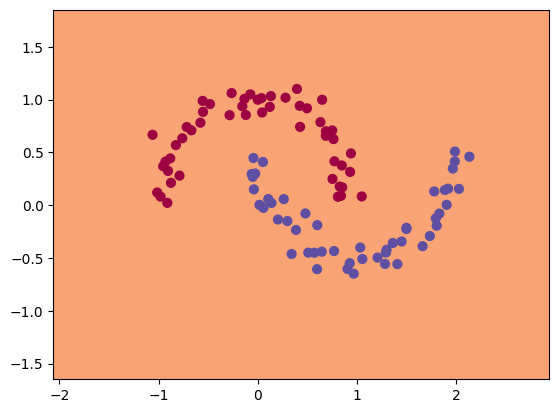

In [13]:

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

